# 🧪 Custom Logistic Regression

In this notebook, we implement logistic regression **from scratch** using Stochastic Gradient Descent. We then compare the performance of these implementations with **scikit-learn**'s `LogisticRegression` model.

### ⚙️ Importing Libraries & Environment Setup

In [ ]:
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

In [37]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [ ]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [ ]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [40]:
# Generate dataset
X, y = make_classification(
    n_samples=100,
    n_features=5,
    n_informative=3,
    n_classes=2,
    n_redundant=0,
    random_state=42,
)

In [41]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [ ]:
class MyLogisticRegression:
    """Logistic Regression classifier using SGD with L1 and L2 regularization.

    This implementation uses batch size 1 (pure SGD) to optimize the logistic loss,
    supporting both L1 (Lasso) and L2 (Ridge) penalties to reduce overfitting and
    promote sparsity.

    Attributes:
        max_epochs (int): Maximum number of training epochs.
        learning_rate (float): Learning rate for parameter updates.
        tolerance (float): Threshold for convergence based on change in loss.
        lambda_l1 (float): Strength of L1 regularization.
        lambda_l2 (float): Strength of L2 regularization.
        coef_ (NDArray[np.float64] | None): Model coefficients (weights).
        intercept_ (float): Model intercept (bias) term.
    """

    def __init__(
        self,
        max_epochs: int = 10000,
        learning_rate: float = 1e-4,
        tolerance: float = 1e-7,
        lambda_l1: float = 0,
        lambda_l2: float = 0,
        random_state: int | None = None,
    ):
        """Initialize the MyLogisticRegression model.

        Args:
            max_epochs (int): Number of epochs for SGD. Default is 10,000.
            learning_rate (float): Step size for weight updates. Default is 1e-4.
            tolerance (float): Early stopping threshold for change in loss.
                Default is 1e-7.
            lambda_l1 (float): L1 regularization strength (sparsity). Default is 0.
            lambda_l2 (float): L2 regularization strength (weight decay). Default is 0.
            random_state (int | None): Seed for reproducible training. Default is None.
        """
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
        self.rng: RandomGenerator = np.random.default_rng(random_state)

        self.coef_: NDArray[np.float64] | None = None
        self.intercept_: float = 0.0

    def _sigmoid(self, z: NDArray[np.float64]) -> NDArray[np.float64]:
        """Compute the sigmoid activation function.

        Args:
            z (NDArray[np.float64]): Input array (can be a scalar, vector, or matrix).

        Returns:
            NDArray[np.float64]: Output after applying the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def _log_loss(
        self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]
    ) -> float:
        """Compute logistic loss between true and predicted probabilities.

        Args:
            y_true (NDArray[np.float64]): True target values.
            y_pred (NDArray[np.float64]): Predicted values.

        Returns:
            float: Mean logistic loss value.
        """
        return -np.mean(
            y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8)
        )

    def _compute_gradients(
        self, x_i: NDArray[np.float64], y_i: float
    ) -> tuple[NDArray[np.float64], float]:
        """Compute gradients of the loss function with respect to weights and bias.

        Args:
            x_i (NDArray[np.float64]): Single input sample of shape (n_features,).
            y_i (float): True target value for the input sample.

        Returns:
            Tuple containing:
                - grad_coef (NDArray[np.float64]): Gradient w.r.t. coefficients.
                - grad_intercept (float): Gradient w.r.t. intercept.
        """
        y_i_pred = self.predict(x_i)
        error_i = y_i_pred - y_i

        grad_coef = x_i * error_i
        if self.lambda_l1 > 0:
            grad_coef += self.lambda_l1 * np.sign(self.coef_)
        if self.lambda_l2 > 0:
            grad_coef += self.lambda_l2 * self.coef_

        grad_intercept = error_i

        return grad_coef, grad_intercept

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Fit the logistic regression model to training data using SGD.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.float64]): Target vector of shape (n_samples,).
        """
        m, n_features = X.shape
        self.coef_ = np.zeros(n_features)

        prev_loss = float("inf")

        for _ in range(self.max_epochs):
            indices = self.rng.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for x_i, y_i in zip(X_shuffled, y_shuffled, strict=False):
                grad_coef, grad_intercept = self._compute_gradients(x_i, y_i)
                self.coef_ -= self.learning_rate * grad_coef
                self.intercept_ -= self.learning_rate * grad_intercept

            y_pred = self.predict(X)
            loss = self._log_loss(y, y_pred)
            loss += self.lambda_l2 * np.sum(self.coef_**2)
            loss += self.lambda_l1 * np.sum(np.abs(self.coef_))

            if abs(prev_loss - loss) < self.tolerance:
                break

            prev_loss = loss

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values using the trained model.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values of shape (n_samples,).

        Raises:
            ValueError: If model has not been trained yet.
        """
        if self.coef_ is None:
            raise ValueError("Model is not trained yet. Call `fit` first.")
        probs = self._sigmoid(X @ self.coef_ + self.intercept_)
        return (probs > 0.5).astype(int)

### 🏋️‍♂️ Model Training

In [43]:
# Scikit-learn logistic regression model
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

# My SGD logistic regression model
my_model = MyLogisticRegression(lambda_l1=1e-2, lambda_l2=1e-2, random_state=42)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [44]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [ ]:
pd.DataFrame(
    data={
        "Coefficients": [sklearn_model.coef_, my_model.coef_],
        "Intercepts": [sklearn_model.intercept_, my_model.intercept_],
    },
    index=["scikit-learn", "my"],
)

,Coefficients,Intercepts
scikit-learn,"[[1.8238816074743904, 0.6794919894400718, 0.65...",-0.0002
my,"[[1.8238816074743904, 0.6794919894400718, 0.65...",-0.0002


In [46]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my
Accuracy,0.850000,0.850000
Precision,0.818182,0.818182
Recall,0.900000,0.900000
F1-score,0.857143,0.857143
ROC AUC,0.850000,0.850000


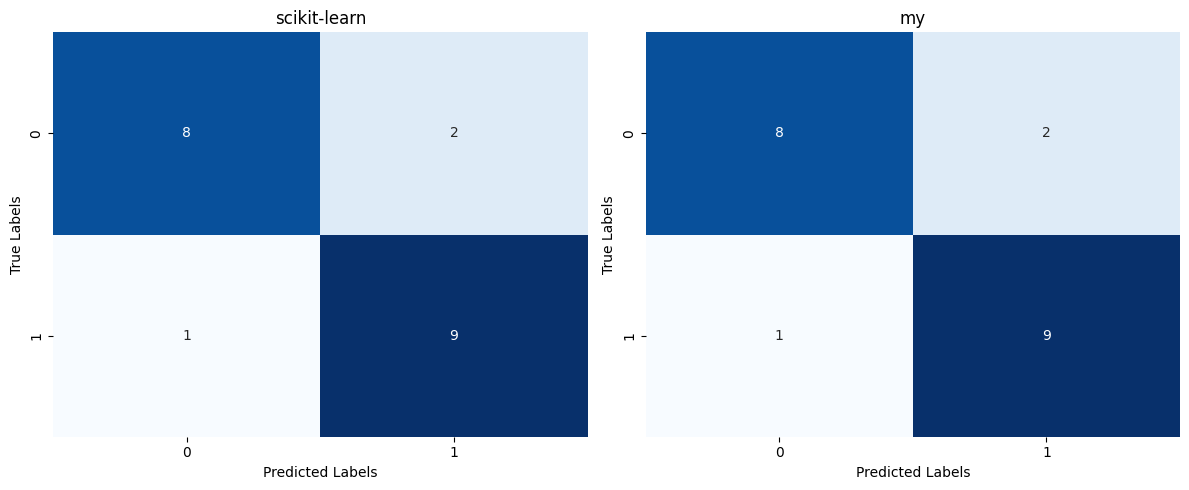

In [47]:
plot_confusion_matrices(predictions, y_test)